In [1]:
import os
import pandas as pd
import numpy as np
import json
import subprocess
from Bio import SeqIO
import plotnine
import dask
from dask import delayed
from dask.distributed import Client
from itertools import combinations
import difflib
import scipy
import random
import pysais
from difflib import SequenceMatcher
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import ahocorasick
from ahocorasick import Automaton
import sys

### Set up functions

In [2]:
def lenset(input_list):
    return len(set(input_list))

def polish_input_frame(input_dir,cluster_threshold,kmer_no,sample_id,sample_code,filename="placeholder",
                       old_dir=False,
                       new_dir=True):
    if old_dir:
        curr_concat_read_in=pd.read_csv(os.path.join(input_dir,sample_id+"_kmerlen_"+str(kmer_no)+\
                                    "_dist_"+str(cluster_threshold)+"progress."+str(sample_code)+".csv"))
    elif new_dir:
        curr_concat_read_in=pd.read_csv(os.path.join(input_dir,filename))
    else:
        curr_concat_read_in=pd.read_csv(os.path.join(input_dir,sample_id+"_kmerlen_"+str(kmer_no)+\
                                    "_dist_"+str(cluster_threshold)+"_"+str(sample_code)+".progress.csv"))

    curr_concat_read_in["sample_code"] = [1 if sample_id in curr else 0 for curr in \
                                  list(curr_concat_read_in.Source_ID)]
    tester_curr=curr_concat_read_in.groupby(["cluster_blob","HomClust"])[["Division","Domain","sample_code"]].\
        agg([set,lenset,len,sum]).reset_index()
    tester_curr.columns = tester_curr.columns.map('|'.join).str.strip('|')
    
    merged_w_eukulele=merged_eukulele.merge(curr_concat_read_in.\
                                  rename({"Source_ID":"Revised_name"},
                                         axis="columns")[["Revised_name","HomClust",
                                                          "cluster_blob"]].\
                                            merge(tester_curr),
                left_on="Revised_name",right_on="Revised_name",how="outer")
    
    return curr_concat_read_in,tester_curr,merged_w_eukulele

def build_upset_df(tester_curr,cluster_threshold):
    
    to_check=tester_curr.loc[[(("Rhizosoleniaceae" in curr)|("Skeletonemataceae" in curr)|\
                              ("Thalassiosiraceae" in curr)|("Hemiaulaceae" in curr))&\
                             (np.nan in curr) for curr in tester_curr["Family|set"]]]

    all_set=set()
    #for curr in to_check["Family|set"]:
    #    all_set.update(curr)
    #all_list_set = list(all_set)
    all_list_set = list(set(["Rhizosoleniaceae","Hemiaulaceae","Skeletonemataceae",
                    "Thalassiosiraceae"])) #+ list(set(tax_table.loc[tax_table.Class=="Bacillariophyta","Family"]))))#[curr.strip() for curr in list(all_set)]

    all_ochrophyte=list(set(tax_table.loc[tax_table.Division=="Ochrophyta","Family"]))
    build_upset_df = pd.DataFrame()
    counter = 0
    for curr in range(len(to_check.index)):
        curr_df = pd.DataFrame()
        for curr_tax in all_list_set:
            curr_tax_label=curr_tax
            if curr_tax != curr_tax:
                curr_tax_label = "Sample_NB"
            if curr_tax in to_check.iloc[curr].loc["Family|set"]:
                curr_df[curr_tax_label] = [True]
            else:
                curr_df[curr_tax_label] = [False]
        curr_df["number_seqs"] = to_check.iloc[curr].loc["sample_code|sum"]
        if len(to_check.iloc[curr].loc["Family|set"].difference(all_list_set)) > 1:
            curr_df["non-diatom"] = [True]
        else:
            curr_df["non-diatom"] = [False]

        if len(to_check.iloc[curr].loc["Family|set"].difference(all_ochrophyte)) > 1:
            curr_df["non-ochrophyte"] = [True]
        else:
            curr_df["non-ochrophyte"] = [False]

        if len(to_check.iloc[curr].loc["Domain|set"].difference(set(["Eukaryota",np.nan]))) > 0:
            curr_df["non-eukaryote"] = [True]
        else:
            curr_df["non-eukaryote"] = [False]
        build_upset_df = pd.concat([build_upset_df,curr_df])
        #if counter > 100:
        #    break
        counter=counter+1
    non_target_diatom=list(set(tax_table.loc[tax_table.Class=="Bacillariophyta","Family"])-
     set(["Rhizosoleniaceae","Hemiaulaceae","Skeletonemataceae","Thalassiosiraceae",
          "Stephanodiscaceae","Chaetocerotales"]))
    build_upset_df["other_diatom"]=build_upset_df[non_target_diatom].any(axis=1)

    build_upset_df = build_upset_df.loc[:,~build_upset_df.columns.duplicated()].copy().\
        groupby(["Rhizosoleniaceae","Hemiaulaceae","Skeletonemataceae",
                 "Thalassiosiraceae","Stephanodiscaceae","Chaetocerotales"]+\
                ["non-diatom","non-eukaryote","non-ochrophyte","other_diatom"])\
        ["number_seqs"].sum()
    
    build_upset_df["Dist"] = cluster_threshold
    return build_upset_df
                            
def aggset(input_set):
    if input_set!=input_set:
        return "NoDeepClustWDiatom"
    return("_".join(sorted(list(set([str(curr) for curr in input_set if curr==curr])))))
                            
def returnagg(merged_eukulele):
    #merged_eukulele["Family|agg"] = [aggset(curr) for curr in merged_eukulele["Family|set"]]
    merged_eukulele["Division|agg"] = [aggset(curr) for curr in merged_eukulele["Division|set"]]

    return merged_eukulele[["Division|agg","Division","Domain",
                            "Division|set","transcript_name","Revised_name"]]

tax_table_file="/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/snakemake-workflows/diamond-deepclust/bats-clustering/bats-eukulele-workflow/bats-eukulele-workflow/radiolaria_marmmetsp/tax-table.txt"
tax_table=pd.read_csv(tax_table_file,sep="\t")
eukaryote_divisions=list(set(tax_table.loc[tax_table.Domain.isin(["Eukaryota"]),"Division"]))

def check_in_euks(list_divisions,division_question):
    if not division_question in list_divisions:
        return False
    for curr_division in list_divisions:
        if not curr_division in eukaryote_divisions:
            return False
        
    return True

### Read in EUKulele databases

In [3]:
EUKulele_MAD_cds_marmmetsp=pd.read_csv("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/snakemake-workflows/diamond-deepclust/bats-clustering/bats-eukulele-workflow/bats-eukulele-workflow/radiolaria_search/taxonomy_estimation/merged.fasta.transdecoder-estimated-taxonomy.out",
                                            sep="\t")

EUKulele_no_rad = pd.read_csv("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/snakemake-workflows/diamond-deepclust/bats-clustering/bats-eukulele-workflow/bats-eukulele-workflow/marmmetsp_search2/taxonomy_estimation/merged.fasta.transdecoder-estimated-taxonomy.out",sep="\t")
import time
import itertools
original_fasta = "/vortexfs1/omics/saito/BATS2019-clio-metaT/eukrhythmic_output/transdecoder_mega_merge_finalproteins/merged.fasta.transdecoder.pep"
behaved_fasta = "bats_fasta_file.fasta"
os.system(" ".join(["bash","/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/remove_newlines.sh",original_fasta,">",behaved_fasta]))

counter=1
start_time=time.time()
sequence_dict=dict()
with open(behaved_fasta,"r") as f:
    counter=1
    for line1,line2 in itertools.zip_longest(*[f]*2):
        sequence_dict[line1.split(">")[1].split(" ")[0]]=line2
        #if counter > 2000000:
        #    break
        counter=counter+1
    print(time.time()-start_time)
    
all_sequences_nb=pd.DataFrame({"transcript_name":list(sequence_dict.keys())})

merged_eukulele=EUKulele_MAD_cds_marmmetsp.merge(all_sequences_nb,how="outer")
merged_eukulele[["Domain","Division","Phylum","Class","Order",
       "Family","Genus","Species"]] = merged_eukulele.full_classification.str.split(pat="; ",n=8,expand=True)

merged_eukulele["Revised_name"] = [str(curr).replace(".","N") for curr in merged_eukulele["transcript_name"]]

merged_eukulele_no_rad=EUKulele_no_rad.merge(all_sequences_nb,how="outer")
merged_eukulele_no_rad[["Domain","Division","Phylum","Class","Order",
       "Family","Genus","Species"]] = merged_eukulele_no_rad.full_classification.str.split(pat="; ",n=8,expand=True)

merged_eukulele_no_rad["Revised_name"] = [str(curr).replace(".","N") for curr in merged_eukulele_no_rad["transcript_name"]]

19.697081327438354


In [85]:
merged_annotations = merged_eukulele_no_rad[["transcript_name","Phylum"]].merge(merged_eukulele[["transcript_name",
                     "Phylum"]].rename({"Phylum":"Phylum2"},axis="columns"))

In [86]:
merged_annotations.loc[(merged_annotations.Phylum2!=merged_annotations.Phylum)&\
                       ((merged_annotations.Phylum=="Ochrophyta")|(merged_annotations.Phylum2=="Ochrophyta"))]

,transcript_name,Phylum,Phylum2
13452,megahit_HN001_k141_167955.p1,Ochrophyta,Retaria
28073,megahit_HN001_k141_236344.p1,Ochrophyta,None
31593,megahit_HN001_k141_253356.p1,Ochrophyta,NaN
40592,megahit_HN001_k141_298052.p1,Ochrophyta,Retaria
44934,megahit_HN001_k141_319637.p1,Ochrophyta,Retaria
...,...,...,...
6275465,velvet_HN044_NODE_267997_length_672_cov_3.9315...,Ochrophyta,Retaria
6276593,velvet_HN044_NODE_286491_length_256_cov_31.441...,Ochrophyta,Retaria
6276628,velvet_HN044_NODE_287002_length_1599_cov_4.894...,Ochrophyta,None
6289638,velvet_HN044_NODE_570667_length_253_cov_6.0909...,Ochrophyta,None


In [5]:
%%time
curr_concat_read_in0_5,tester_curr0_5,merged_w_eukulele0_5=polish_input_frame(input_dir="/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/tax-aliquots/final_and_complete_files",
                                                                              filename="BATS_0.5_Retaria.csv",
                                                                              cluster_threshold=0.5,
                                                                              kmer_no=3,sample_id="k",sample_code="bats")

CPU times: user 4min 14s, sys: 12.6 s, total: 4min 27s
Wall time: 4min 27s


In [4]:
%%time
## this one is for the radiolarians/retaria
curr_concat_read_in0_5_w_names,tester_curr0_5_w_names,merged_w_eukulele0_5_w_names=polish_input_frame(input_dir="/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/tax-aliquots",
                                                                              filename="_HN_kmerlen_3_dist_0.5_bats_retaria_2.progress.csv",
                                                                              cluster_threshold=0.5,
                                                                              kmer_no=3,sample_id="_HN",
                                                                              sample_code="bats",
                                                                              old_dir=False)

CPU times: user 7min 59s, sys: 29.7 s, total: 8min 28s
Wall time: 8min 29s


In [5]:
%%time
## this one is for the radiolarians/retaria
curr_concat_read_in0_5_w_names_hap,tester_curr0_5_w_names_hap,merged_w_eukulele0_5_w_names_hap=polish_input_frame(input_dir="/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/tax-aliquots",
                                                                              filename="_HN_kmerlen_3_dist_0.5_diatoms.progress.csv",
                                                                              cluster_threshold=0.5,
                                                                              kmer_no=3,sample_id="_HN",
                                                                              sample_code="bats",
                                                                              old_dir=False)

CPU times: user 7min 35s, sys: 23.9 s, total: 7min 59s
Wall time: 8min


In [7]:

curr_concat_read_in0_5_w_names_hap.groupby(["Division"]).cluster_blob.count().reset_index()

,Division,cluster_blob
0,Actinobacteria,11944
1,Alphaproteobacteria,75889
2,Bacteroidetes/Chlorobi group,7167
3,Betaproteobacteria,2013
4,Cyanobacteria/Melainabacteria group,2391
...,...,...
67,Zetaproteobacteria,2499
68,delta/epsilon subdivisions,41749
69,unclassified Acidobacteria,1649
70,unclassified Bacteria (miscellaneous),1604


In [11]:
def get_merged_w_agg(merged_w_eukulele0_5_w_names):
    merged_w_eukulele0_5_agg=returnagg(merged_w_eukulele0_5_w_names)
    merged_w_eukulele0_5_agg=merged_w_eukulele0_5_agg.merge(merged_eukulele_no_rad[["Revised_name","Phylum",
                                                          "Family"]].rename({"Phylum":"Phylum_BLAST1",
                                                                             "Family":"Family_BLAST1"},
                                                                            axis="columns"),left_on="Revised_name",
                                   right_on="Revised_name",how="outer").\
                                merge(merged_eukulele[["Revised_name","Phylum",
                                                          "Family"]].rename({"Phylum":"Phylum_BLAST2",
                                                                             "Family":"Family_BLAST2"},
                                                                            axis="columns"),left_on="Revised_name",
                                   right_on="Revised_name",how="outer")
    merged_w_eukulele0_5_agg["Family_BLAST1"]=["Unannotated" if (curr!=curr)|(curr is None) else curr for curr in merged_w_eukulele0_5_agg["Family_BLAST1"]]
    merged_w_eukulele0_5_agg["Division"]=["Unannotated" if (curr!=curr)|(curr is None) else curr for curr in merged_w_eukulele0_5_agg["Division"]]
    merged_w_eukulele0_5_agg["Phylum_BLAST1"]=["Unannotated" if (curr!=curr)|(curr is None) else curr for curr in merged_w_eukulele0_5_agg["Phylum_BLAST1"]]
    merged_w_eukulele0_5_agg["Family_BLAST2"]=["Unannotated" if (curr!=curr)|(curr is None) else curr for curr in merged_w_eukulele0_5_agg["Family_BLAST2"]]
    merged_w_eukulele0_5_agg["Phylum_BLAST2"]=["Unannotated" if (curr!=curr)|(curr is None) else curr for curr in merged_w_eukulele0_5_agg["Phylum_BLAST2"]]
    merged_w_eukulele0_5_agg["Name"] = [str(curr).split(".p")[0] for curr in merged_w_eukulele0_5_agg["transcript_name"]]

    return merged_w_eukulele0_5_agg

merged_w_eukulele0_5_w_names_hap_agg = get_merged_w_agg(merged_w_eukulele0_5_w_names_hap)

In [20]:
merged_w_eukulele0_5_w_names_hap_agg.groupby("Division|agg")\
    .transcript_name.count().reset_index().sort_values("transcript_name",ascending=False).head(n=20)


,Division|agg,transcript_name
2258,NoDeepClustWDiatom,8153674
0,,2852418
1903,Dinoflagellata,126433
2124,Gammaproteobacteria,71505
2204,Haptophyta,61771
1852,Cyanobacteria,54534
550,Alphaproteobacteria,46206
2259,Ochrophyta,45023
1922,Dinoflagellata_Foraminifera,23749
431,Gammaproteobacteria_Gammaproteobacteria,16469


In [17]:
merged_w_eukulele0_5_agg=returnagg(merged_w_eukulele0_5_w_names)
merged_w_eukulele0_5_agg=merged_w_eukulele0_5_agg.merge(merged_eukulele_no_rad[["Revised_name","Phylum",
                                                      "Family"]].rename({"Phylum":"Phylum_BLAST1",
                                                                         "Family":"Family_BLAST1"},
                                                                        axis="columns"),left_on="Revised_name",
                               right_on="Revised_name",how="outer").\
                            merge(merged_eukulele[["Revised_name","Phylum",
                                                      "Family"]].rename({"Phylum":"Phylum_BLAST2",
                                                                         "Family":"Family_BLAST2"},
                                                                        axis="columns"),left_on="Revised_name",
                               right_on="Revised_name",how="outer")
merged_w_eukulele0_5_agg["Family_BLAST1"]=["Unannotated" if (curr!=curr)|(curr is None) else curr for curr in merged_w_eukulele0_5_agg["Family_BLAST1"]]
merged_w_eukulele0_5_agg["Division"]=["Unannotated" if (curr!=curr)|(curr is None) else curr for curr in merged_w_eukulele0_5_agg["Division"]]
merged_w_eukulele0_5_agg["Phylum_BLAST1"]=["Unannotated" if (curr!=curr)|(curr is None) else curr for curr in merged_w_eukulele0_5_agg["Phylum_BLAST1"]]
merged_w_eukulele0_5_agg["Family_BLAST2"]=["Unannotated" if (curr!=curr)|(curr is None) else curr for curr in merged_w_eukulele0_5_agg["Family_BLAST2"]]
merged_w_eukulele0_5_agg["Phylum_BLAST2"]=["Unannotated" if (curr!=curr)|(curr is None) else curr for curr in merged_w_eukulele0_5_agg["Phylum_BLAST2"]]
merged_w_eukulele0_5_agg["Name"] = [str(curr).split(".p")[0] for curr in merged_w_eukulele0_5_agg["transcript_name"]]

merged_w_eukulele0_5_cts=merged_w_eukulele0_5_agg.loc[merged_w_eukulele0_5_agg["Division|agg"] == \
                                                  merged_w_eukulele0_5_agg["Division"]]

In [21]:
merged_w_eukulele0_5_agg.groupby("Division|agg")\
    .transcript_name.count().reset_index().sort_values("transcript_name",ascending=False).head(n=20)

,Division|agg,transcript_name
2250,NoDeepClustWDiatom,7737546
0,,3241660
1896,Dinoflagellata,140145
2198,Haptophyta,97553
2122,Gammaproteobacteria,63382
1845,Cyanobacteria,51915
2251,Ochrophyta,39434
520,Alphaproteobacteria,37904
1915,Dinoflagellata_Foraminifera,26117
1082,Chlorophyta,19594


In [6]:
merged_w_eukulele0_5_agg.loc[(merged_w_eukulele0_5_agg["Division|agg"]=='Retaria')&\
                             (merged_w_eukulele0_5_agg["Phylum_BLAST2"]=="Unannotated")&\
                             (merged_w_eukulele0_5_agg.transcript_name==\
                              merged_w_eukulele0_5_agg.transcript_name)]

,Division|agg,Division,Domain,Division|set,transcript_name,Revised_name,Phylum_BLAST1,Family_BLAST1,Phylum_BLAST2,Family_BLAST2,Name
1244,Retaria,Unannotated,Eukaryota,"{nan, Retaria}",megahit_HN001_k141_10693.p2,megahit_HN001_k141_10693Np2,Ciliophora,Strombidinopsidae,Unannotated,Unannotated,megahit_HN001_k141_10693
3733,Retaria,Unannotated,NaN,"{nan, Retaria}",megahit_HN001_k141_119884.p1,megahit_HN001_k141_119884Np1,Unannotated,Unannotated,Unannotated,Unannotated,megahit_HN001_k141_119884
8897,Retaria,Unannotated,Eukaryota,"{nan, Retaria}",megahit_HN001_k141_145512.p1,megahit_HN001_k141_145512Np1,Unannotated,Unannotated,Unannotated,Unannotated,megahit_HN001_k141_145512
27219,Retaria,Unannotated,Eukaryota,"{nan, Retaria}",megahit_HN001_k141_232352.p1,megahit_HN001_k141_232352Np1,Unannotated,Unannotated,Unannotated,Unannotated,megahit_HN001_k141_232352
28107,Retaria,Unannotated,Eukaryota,"{nan, Retaria}",megahit_HN001_k141_236257.p1,megahit_HN001_k141_236257Np1,Ciliophora,Unannotated,Unannotated,Unannotated,megahit_HN001_k141_236257
...,...,...,...,...,...,...,...,...,...,...,...
11408688,Retaria,Unannotated,NaN,"{nan, Retaria}",velvet_HN031_NODE_148104_length_509_cov_5.3988...,velvet_HN031_NODE_148104_length_509_cov_5N3988...,Unannotated,Unannotated,Unannotated,Unannotated,velvet_HN031_NODE_148104_length_509_cov_5.398821
11415797,Retaria,Unannotated,NaN,"{nan, Retaria}",velvet_HN031_NODE_350851_length_837_cov_4.0991...,velvet_HN031_NODE_350851_length_837_cov_4N0991...,Unannotated,Unannotated,Unannotated,Unannotated,velvet_HN031_NODE_350851_length_837_cov_4.099164
11450337,Retaria,Unannotated,NaN,"{nan, Retaria}",velvet_HN033_NODE_259052_length_365_cov_8.0739...,velvet_HN033_NODE_259052_length_365_cov_8N0739...,Unannotated,Unannotated,Unannotated,Unannotated,velvet_HN033_NODE_259052_length_365_cov_8.073973
11452685,Retaria,Unannotated,NaN,"{nan, Retaria}",velvet_HN033_NODE_299065_length_337_cov_8.5934...,velvet_HN033_NODE_299065_length_337_cov_8N5934...,Unannotated,Unannotated,Unannotated,Unannotated,velvet_HN033_NODE_299065_length_337_cov_8.593472


In [23]:
merged_w_eukulele0_5_agg[["Revised_name","Division|agg"]].loc[[("MMETSP" not in curr) & ("MMP" not in curr)& ("EP" not in curr)\
                                                                 for curr in \
                                                                 merged_w_eukulele0_5_agg.Revised_name]].\
    sort_values("Division|agg")

,Revised_name,Division|agg
5910877,velvet_HN030_NODE_127948_length_792_cov_14N833...,
3694332,trinity_HN017_TRINITY_DN7582_c0_g1_i1Np3,
3694333,trinity_HN017_TRINITY_DN7582_c0_g2_i1Np1,
3694335,trinity_HN017_TRINITY_DN75839_c0_g1_i1Np1,
3694336,trinity_HN017_TRINITY_DN75839_c0_g2_i1Np2,
...,...,...
3957418,trinity_HN021_TRINITY_DN4574_c0_g1_i5Np1,unclassified Euryarchaeota
5439424,velvet_HN014_NODE_104601_length_293_cov_7N3617...,unclassified Euryarchaeota
5697859,velvet_HN021_NODE_428202_length_515_cov_3N6097...,unclassified Euryarchaeota
5696720,velvet_HN021_NODE_395266_length_352_cov_4N2982...,unclassified Euryarchaeota


In [72]:
merged_cts=merged_w_eukulele0_5_agg.loc[merged_w_eukulele0_5_agg.transcript_name==\
                                        merged_w_eukulele0_5_agg.transcript_name].\
    groupby(["Division","Phylum_BLAST1","Phylum_BLAST2",
                                             "Division|agg"]).transcript_name.count().reset_index().\
    sort_values("transcript_name",ascending=False)
merged_cts=merged_cts.loc[merged_cts.transcript_name>0]

division_question="Retaria"
retaria_subframe = merged_cts.loc[((merged_cts.Phylum_BLAST2==division_question)|\
               ([division_question in curr for curr in merged_cts["Division|agg"]]))]
retaria_subframe["AnnotationType_Old"] = ["BLAST LCA, tax-aliquots coherent" if (div_curr==division_question) & \
                                       (division_question==div_agg)\
                                       else "BLAST LCA, tax-aliquots mixed" if (div_curr==division_question)&\
                                       (division_question in div_agg) else "BLAST LCA" if \
                                       (div_curr==division_question)\
                                       else "tax-aliquots coherent" if (division_question==div_agg)\
                                       else "tax-aliquots eukaryote" if check_in_euks(div_agg.split("_"),division_question)\
                                       else "tax-aliquots" if div_agg!="NoDeepClustWDiatom" \
                                       else "no annotation" for div_agg,div_curr in \
                                       zip(retaria_subframe["Division|agg"],
                                           retaria_subframe["Phylum_BLAST2"])]

retaria_subframe["AnnotationType"] = ["BLAST LCA, tax-aliquots coherent" if (div_curr==division_question) & \
                                       (division_question==div_agg)\
                                       else "BLAST LCA, tax-aliquots mixed" if (div_curr==division_question)&\
                                       (division_question in div_agg)  else \
                                        "BLAST LCA, tax-aliquots disagrees" if \
                                       (div_curr==division_question) & (div_agg != "") & (div_agg != "NoDeepClustWDiatom") \
                                        else "BLAST LCA" if \
                                       (div_curr==division_question)\
                                       else "tax-aliquots coherent" if (division_question==div_agg)&(div_curr=="Unannotated")\
                                       else "tax-aliquots coherent,BLAST LCA disagrees" if (division_question==div_agg)&(div_curr!="Unannotated")\
                                       else "tax-aliquots eukaryote" if check_in_euks(div_agg.split("_"),division_question)\
                                       else "tax-aliquots" if (div_agg!="NoDeepClustWDiatom")&(div_agg!="") \
                                       else "no annotation" for div_agg,div_curr in \
                                       zip(retaria_subframe["Division|agg"],
                                       retaria_subframe["Phylum_BLAST2"])]

retaria_subframe["AnnotationType_preret"] = ["BLAST LCA, tax-aliquots coherent" if (div_curr==division_question) & \
                                       (division_question==div_agg)\
                                       else "BLAST LCA, tax-aliquots mixed" if (div_curr==division_question)&\
                                       (division_question in div_agg)  else \
                                        "BLAST LCA, tax-aliquots disagrees" if \
                                       (div_curr==division_question) & (div_agg != "") & (div_agg != "NoDeepClustWDiatom") \
                                        else "BLAST LCA" if \
                                       (div_curr==division_question)\
                                       else "tax-aliquots coherent" if (division_question==div_agg)&(div_curr=="Unannotated")\
                                       else "tax-aliquots coherent,BLAST LCA disagrees" if (division_question==div_agg)&(div_curr!="Unannotated")\
                                       else "tax-aliquots eukaryote" if check_in_euks(div_agg.split("_"),division_question)\
                                       else "tax-aliquots" if (div_agg!="NoDeepClustWDiatom")&(div_agg!="")\
                                       else "no annotation" for div_agg,div_curr in \
                                       zip(retaria_subframe["Division|agg"],
                                       retaria_subframe["Phylum_BLAST1"])]

<ipython-input-72-12e933ec4915>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-72-12e933ec4915>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-72-12e933ec4915>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [74]:
retaria_subframe

,Division,Phylum_BLAST1,Phylum_BLAST2,Division|agg,transcript_name,AnnotationType_Old,AnnotationType,AnnotationType_preret
4071,Rhizaria,Unannotated,Retaria,,20945,BLAST LCA,BLAST LCA,no annotation
4211,Rhizaria,Unannotated,Retaria,NoDeepClustWDiatom,17711,BLAST LCA,BLAST LCA,no annotation
5992,Unannotated,Unannotated,Unannotated,Apicomplexa_Cercozoa_Chlorophyta_Ciliophora_Co...,11492,tax-aliquots,tax-aliquots,tax-aliquots
3946,Rhizaria,Foraminifera,Retaria,,10238,BLAST LCA,BLAST LCA,no annotation
3821,Rhizaria,Ciliophora,Retaria,NoDeepClustWDiatom,5177,BLAST LCA,BLAST LCA,no annotation
...,...,...,...,...,...,...,...,...
2474,Hacrobia,Haptophyta,Haptophyta,Chlorophyta_Retaria,1,tax-aliquots eukaryote,tax-aliquots eukaryote,tax-aliquots eukaryote
2520,Hacrobia,Haptophyta,Haptophyta,Ciliophora_Dinoflagellata_Haptophyta_Retaria,1,tax-aliquots eukaryote,tax-aliquots eukaryote,tax-aliquots eukaryote
2560,Hacrobia,Haptophyta,Haptophyta,Cryptophyta_Dinoflagellata_Retaria_Stramenopil...,1,tax-aliquots,tax-aliquots,tax-aliquots
2533,Hacrobia,Haptophyta,Haptophyta,Ciliophora_Retaria,1,tax-aliquots eukaryote,tax-aliquots eukaryote,tax-aliquots eukaryote


In [76]:
retaria_subframe.groupby(["Phylum_BLAST1","Phylum_BLAST2",
                          "AnnotationType","AnnotationType_preret"]).transcript_name.sum().\
    reset_index().sort_values("transcript_name",ascending=False)

,Phylum_BLAST1,Phylum_BLAST2,AnnotationType,AnnotationType_preret,transcript_name
201,Unannotated,Unannotated,tax-aliquots,tax-aliquots,40987
196,Unannotated,Retaria,BLAST LCA,no annotation,38657
203,Unannotated,Unannotated,tax-aliquots eukaryote,tax-aliquots eukaryote,16002
107,Foraminifera,Retaria,BLAST LCA,no annotation,12428
118,Gammaproteobacteria,Gammaproteobacteria,tax-aliquots,tax-aliquots,8079
...,...,...,...,...,...
135,Hacrobia_X,Retaria,"BLAST LCA, tax-aliquots coherent","tax-aliquots coherent,BLAST LCA disagrees",1
95,Discoba,Discoba,tax-aliquots,tax-aliquots,1
133,Glaucophyta,Unannotated,tax-aliquots coherent,"tax-aliquots coherent,BLAST LCA disagrees",1
22,Bacteroidetes/Chlorobi group,Retaria,"BLAST LCA, tax-aliquots coherent","tax-aliquots coherent,BLAST LCA disagrees",1


In [25]:
retaria_subframe.loc[retaria_subframe["AnnotationType"] == "tax-aliquots coherent,BLAST LCA disagrees"].transcript_name.sum()

1513

In [26]:
retaria_subframe.loc[retaria_subframe["AnnotationType"] == "tax-aliquots coherent"].transcript_name.sum()

1526

In [27]:
retaria_subframe.loc[retaria_subframe["Phylum_BLAST2"] =="Retaria"]

,Division,Phylum_BLAST1,Phylum_BLAST2,Division|agg,transcript_name,AnnotationType_Old,AnnotationType
4071,Rhizaria,Unannotated,Retaria,,20945,BLAST LCA,BLAST LCA
3946,Rhizaria,Foraminifera,Retaria,,10238,BLAST LCA,BLAST LCA
3840,Rhizaria,Dinoflagellata,Retaria,,4461,BLAST LCA,BLAST LCA
4030,Rhizaria,Haptophyta,Retaria,,3326,BLAST LCA,BLAST LCA
4214,Rhizaria,Unannotated,Retaria,Retaria,2773,"BLAST LCA, tax-aliquots coherent","BLAST LCA, tax-aliquots coherent"
...,...,...,...,...,...,...,...
4213,Rhizaria,Unannotated,Retaria,Perkinsea,1,BLAST LCA,"BLAST LCA, tax-aliquots disagrees"
4216,Rhizaria,Unannotated,Retaria,Rhodophyta,1,BLAST LCA,"BLAST LCA, tax-aliquots disagrees"
4217,Rhizaria,Unannotated,Retaria,Sagenista,1,BLAST LCA,"BLAST LCA, tax-aliquots disagrees"
4218,Rhizaria,Unannotated,Retaria,Stramenopiles_X,1,BLAST LCA,"BLAST LCA, tax-aliquots disagrees"


In [28]:
merged_cts.loc[merged_cts["Division|agg"]=="Retaria"]

,Division,Phylum_BLAST1,Phylum_BLAST2,Division|agg,transcript_name
4214,Rhizaria,Unannotated,Retaria,Retaria,2773
3965,Rhizaria,Foraminifera,Retaria,Retaria,1987
7010,Unannotated,Unannotated,Unannotated,Retaria,782
3679,Rhizaria,Alphaproteobacteria,Retaria,Retaria,718
3412,Proteobacteria,Gammaproteobacteria,Gammaproteobacteria,Retaria,609
...,...,...,...,...,...
3676,Rhizaria,Actinobacteria,Retaria,Retaria,1
5554,Unannotated,Glaucophyta,Unannotated,Retaria,1
5319,Unannotated,Bacteroidetes/Chlorobi group,Unannotated,Retaria,1
5646,Unannotated,Thaumarchaeota,Unannotated,Retaria,1


In [29]:
merged_cts.loc[merged_cts["Division|agg"]=="Retaria"]

,Division,Phylum_BLAST1,Phylum_BLAST2,Division|agg,transcript_name
4214,Rhizaria,Unannotated,Retaria,Retaria,2773
3965,Rhizaria,Foraminifera,Retaria,Retaria,1987
7010,Unannotated,Unannotated,Unannotated,Retaria,782
3679,Rhizaria,Alphaproteobacteria,Retaria,Retaria,718
3412,Proteobacteria,Gammaproteobacteria,Gammaproteobacteria,Retaria,609
...,...,...,...,...,...
3676,Rhizaria,Actinobacteria,Retaria,Retaria,1
5554,Unannotated,Glaucophyta,Unannotated,Retaria,1
5319,Unannotated,Bacteroidetes/Chlorobi group,Unannotated,Retaria,1
5646,Unannotated,Thaumarchaeota,Unannotated,Retaria,1


In [77]:
division_question="Ochrophyta"

merged_cts_ochr=merged_w_eukulele0_5_w_names_hap_agg.loc[merged_w_eukulele0_5_w_names_hap_agg.transcript_name==\
                                        merged_w_eukulele0_5_w_names_hap_agg.transcript_name].\
    groupby(["Division","Phylum_BLAST1","Phylum_BLAST2",
                                             "Division|agg"]).transcript_name.count().reset_index().\
    sort_values("transcript_name",ascending=False)
merged_cts_ochr=merged_cts_ochr.loc[merged_cts_ochr.transcript_name>0]

diatom_subframe = merged_cts_ochr.loc[((merged_cts_ochr.Phylum_BLAST1==division_question)|\
                                       (merged_cts_ochr.Phylum_BLAST2==division_question)|\
               ([division_question in curr for curr in merged_cts_ochr["Division|agg"]]))]
diatom_subframe["AnnotationType_Old"] = ["BLAST LCA, tax-aliquots coherent" if (div_curr==division_question) & \
                                       (division_question==div_agg)\
                                       else "BLAST LCA, tax-aliquots mixed" if (div_curr==division_question)&\
                                       (division_question in div_agg) else "BLAST LCA" if \
                                       (div_curr==division_question)\
                                       else "tax-aliquots coherent" if (division_question==div_agg)\
                                       else "tax-aliquots eukaryote" if check_in_euks(div_agg.split("_"),division_question)\
                                       else "tax-aliquots" for div_agg,div_curr in \
                                       zip(diatom_subframe["Division|agg"],
                                           diatom_subframe["Phylum_BLAST2"])]

diatom_subframe["AnnotationType"] = ["BLAST LCA, tax-aliquots coherent" if (div_curr==division_question) & \
                                       (division_question==div_agg)\
                                       else "BLAST LCA, tax-aliquots mixed" if (div_curr==division_question)&\
                                       (division_question in div_agg)  else \
                                        "BLAST LCA, tax-aliquots disagrees" if \
                                       (div_curr==division_question) & (div_agg != "") & (div_agg != "NoDeepClustWDiatom") \
                                        else "BLAST LCA" if \
                                       (div_curr==division_question)\
                                       else "tax-aliquots coherent" if (division_question==div_agg)&(div_curr=="Unannotated")\
                                       else "tax-aliquots coherent,BLAST LCA disagrees" if (division_question==div_agg)&(div_curr!="Unannotated")\
                                       else "tax-aliquots eukaryote" if check_in_euks(div_agg.split("_"),division_question)\
                                       else "tax-aliquots" if (div_agg!="NoDeepClustWDiatom")&(div_agg!="") \
                                       else "no annotation" for div_agg,div_curr in \
                                       zip(diatom_subframe["Division|agg"],
                                       diatom_subframe["Phylum_BLAST2"])]

diatom_subframe["AnnotationType_preret"] = ["BLAST LCA, tax-aliquots coherent" if (div_curr==division_question) & \
                                       (division_question==div_agg)\
                                       else "BLAST LCA, tax-aliquots mixed" if (div_curr==division_question)&\
                                       (division_question in div_agg)  else \
                                        "BLAST LCA, tax-aliquots disagrees" if \
                                       (div_curr==division_question) & (div_agg != "") & (div_agg != "NoDeepClustWDiatom") \
                                        else "BLAST LCA" if \
                                       (div_curr==division_question)\
                                       else "tax-aliquots coherent" if (division_question==div_agg)&(div_curr=="Unannotated")\
                                       else "tax-aliquots coherent,BLAST LCA disagrees" if (division_question==div_agg)&(div_curr!="Unannotated")\
                                       else "tax-aliquots eukaryote" if check_in_euks(div_agg.split("_"),division_question)\
                                       else "tax-aliquots" if (div_agg!="NoDeepClustWDiatom")&(div_agg!="")\
                                       else "no annotation" for div_agg,div_curr in \
                                       zip(diatom_subframe["Division|agg"],
                                       diatom_subframe["Phylum_BLAST1"])]

<ipython-input-77-8907d9929997>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-77-8907d9929997>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-77-8907d9929997>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [90]:
np.sum(diatom_subframe[(diatom_subframe.Phylum_BLAST1!=diatom_subframe.Phylum_BLAST2)&\
                ((diatom_subframe.Phylum_BLAST1=="Ochrophyta")|(diatom_subframe.Phylum_BLAST2=="Ochrophyta"))].transcript_name)

3025

In [94]:
diatom_subframe.loc[diatom_subframe.Phylum_BLAST1=="Ochrophyta"].groupby("AnnotationType_preret").\
    transcript_name.sum().reset_index()

,AnnotationType_preret,transcript_name
0,BLAST LCA,287427
1,"BLAST LCA, tax-aliquots coherent",35694
2,"BLAST LCA, tax-aliquots disagrees",1482
3,"BLAST LCA, tax-aliquots mixed",8607


In [96]:
(35694+1482+8607+287427)

333210

In [95]:
35694/(35694+1482+8607+287427)

0.10712163500495184

In [82]:
diatom_subframe[diatom_subframe.Phylum_BLAST1!=diatom_subframe.Phylum_BLAST2].\
    sort_values("transcript_name",ascending=False).groupby("AnnotationType").\
    transcript_name.sum().reset_index().sort_values("transcript_name",ascending=False)

,AnnotationType,transcript_name
7,tax-aliquots eukaryote,2945
3,no annotation,2890
4,tax-aliquots,1768
5,tax-aliquots coherent,98
6,"tax-aliquots coherent,BLAST LCA disagrees",46
0,BLAST LCA,19
1,"BLAST LCA, tax-aliquots disagrees",1
2,"BLAST LCA, tax-aliquots mixed",1


In [87]:
np.sum(diatom_subframe[diatom_subframe.Phylum_BLAST1!=diatom_subframe.Phylum_BLAST2].\
    sort_values("transcript_name",ascending=False).groupby("AnnotationType").\
    transcript_name.sum().reset_index().sort_values("transcript_name",ascending=False).transcript_name)

7768

In [31]:
division_question="Haptophyta"
haptophyta_subframe = merged_cts.loc[((merged_cts.Phylum_BLAST2==division_question)|\
               ([division_question in curr for curr in merged_cts["Division|agg"]]))&\
                                 (merged_cts["Division|agg"]!="NoDeepClustWDiatom")&\
                                 (merged_cts["Division|agg"]!="")]
haptophyta_subframe["AnnotationType_Old"] = ["BLAST LCA, tax-aliquots coherent" if (div_curr==division_question) & \
                                       (division_question==div_agg)\
                                       else "BLAST LCA, tax-aliquots mixed" if (div_curr==division_question)&\
                                       (division_question in div_agg) else "BLAST LCA" if \
                                       (div_curr==division_question)\
                                       else "tax-aliquots coherent" if (division_question==div_agg)\
                                       else "tax-aliquots eukaryote" if check_in_euks(div_agg.split("_"),division_question)\
                                       else "tax-aliquots" for div_agg,div_curr in \
                                       zip(haptophyta_subframe["Division|agg"],
                                           haptophyta_subframe["Phylum_BLAST2"])]

haptophyta_subframe["AnnotationType"] =  ["BLAST LCA, tax-aliquots coherent" if (div_curr==division_question) & \
                                           (division_question==div_agg)\
                                           else "BLAST LCA, tax-aliquots mixed" if (div_curr==division_question)&\
                                           (division_question in div_agg)  else \
                                            "BLAST LCA, tax-aliquots disagrees" if \
                                           (div_curr==division_question) & (div_agg != "") & (div_agg != "NoDeepClustWDiatom") \
                                            else "BLAST LCA" if \
                                           (div_curr==division_question)\
                                           else "tax-aliquots coherent" if (division_question==div_agg)&(div_curr=="Unannotated")\
                                           else "tax-aliquots coherent,BLAST LCA disagrees" if (division_question==div_agg)&(div_curr!="Unannotated")\
                                           else "tax-aliquots eukaryote" if check_in_euks(div_agg.split("_"),division_question)\
                                           else "tax-aliquots" for div_agg,div_curr in \
                                           zip(haptophyta_subframe["Division|agg"],
                                           haptophyta_subframe["Phylum_BLAST2"])]

<ipython-input-31-f53cafce2a01>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-31-f53cafce2a01>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
haptophyta_subframe.loc[haptophyta_subframe["AnnotationType"] == \
                        "tax-aliquots coherent,BLAST LCA disagrees"].transcript_name.sum()

964

In [125]:
haptophyta_subframe.loc[haptophyta_subframe["AnnotationType"] == \
                        "tax-aliquots coherent"].transcript_name.sum()

3237

In [126]:
haptophyta_subframe.loc[haptophyta_subframe["AnnotationType"] == \
                        "tax-aliquots coherent"]

,Division,Phylum_BLAST1,Phylum_BLAST2,Division|agg,transcript_name,AnnotationType_Old,AnnotationType
6964,Unannotated,Unannotated,Unannotated,Haptophyta,2644,tax-aliquots coherent,tax-aliquots coherent
5589,Unannotated,Haptophyta,Unannotated,Haptophyta,477,tax-aliquots coherent,tax-aliquots coherent
2747,Hacrobia,Unannotated,Unannotated,Haptophyta,66,tax-aliquots coherent,tax-aliquots coherent
1681,Archaeplastida,Unannotated,Unannotated,Haptophyta,16,tax-aliquots coherent,tax-aliquots coherent
5277,Terrabacteria group,Unannotated,Unannotated,Haptophyta,13,tax-aliquots coherent,tax-aliquots coherent
1131,Alveolata,Unannotated,Unannotated,Haptophyta,6,tax-aliquots coherent,tax-aliquots coherent
5478,Unannotated,Dinoflagellata,Unannotated,Haptophyta,5,tax-aliquots coherent,tax-aliquots coherent
4977,Stramenopiles,Unannotated,Unannotated,Haptophyta,4,tax-aliquots coherent,tax-aliquots coherent
3593,Proteobacteria,Unannotated,Unannotated,Haptophyta,2,tax-aliquots coherent,tax-aliquots coherent
5618,Unannotated,Ochrophyta,Unannotated,Haptophyta,2,tax-aliquots coherent,tax-aliquots coherent


In [41]:
retaria_group=retaria_subframe.groupby(["AnnotationType"]).transcript_name.sum().reset_index()
retaria_group["Phylum"]="Retaria"
diatom_group=diatom_subframe.groupby(["AnnotationType"]).transcript_name.sum().reset_index()
diatom_group["Phylum"]="Ochrophyta"
haptophyte_group=haptophyta_subframe.groupby(["AnnotationType"]).transcript_name.sum().reset_index()
haptophyte_group["Phylum"]="Haptophyta"
concat_frame=pd.concat([retaria_group,diatom_group,haptophyte_group])
concat_frame["AnnotationTypeCat"] = pd.Categorical(concat_frame["AnnotationType"],
                                                categories=["BLAST LCA","BLAST LCA, tax-aliquots disagrees",
                                                            "BLAST LCA, tax-aliquots coherent",
                                                            "BLAST LCA, tax-aliquots mixed",
                                                            "tax-aliquots",
                                                            "tax-aliquots coherent,BLAST LCA disagrees",
                                                            "tax-aliquots eukaryote",
                                                            "tax-aliquots coherent"],ordered=True)

diatom_plot = (plotnine.ggplot(concat_frame) + plotnine.geom_bar(plotnine.aes(x="Phylum",y="transcript_name",
                                                                fill="AnnotationType"),stat="identity") + \
    plotnine.xlab("") + \
    plotnine.ylab("Number of sequences") + \
    plotnine.scale_fill_manual(values=["#CC5500","#F28C28","#DAA06D","#F0FFFF","#89CFF0","#0047AB","black","gray"],
                               name="Annotation origin")+\
    plotnine.theme_classic(base_size=12))


/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.


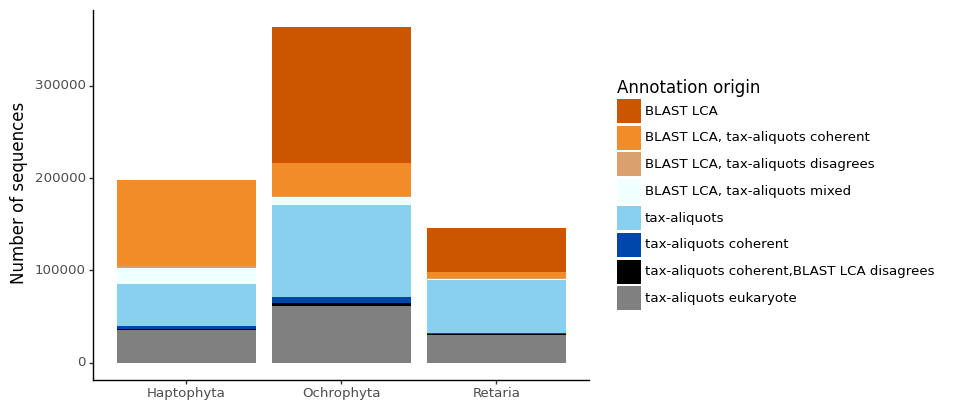

<ggplot: (2933847381724)>

In [42]:
diatom_plot

/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.


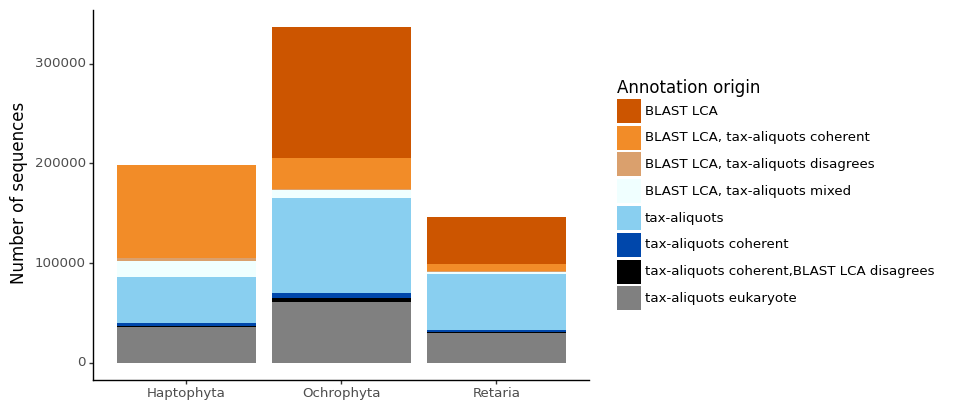

<ggplot: (2933846827219)>

In [37]:
diatom_plot

In [22]:
diatom_plot

NameError: name 'diatom_plot' is not defined

/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: retaria_tax_aliquots.pdf
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/utils.py:370: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/facets/facet.py:549: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.

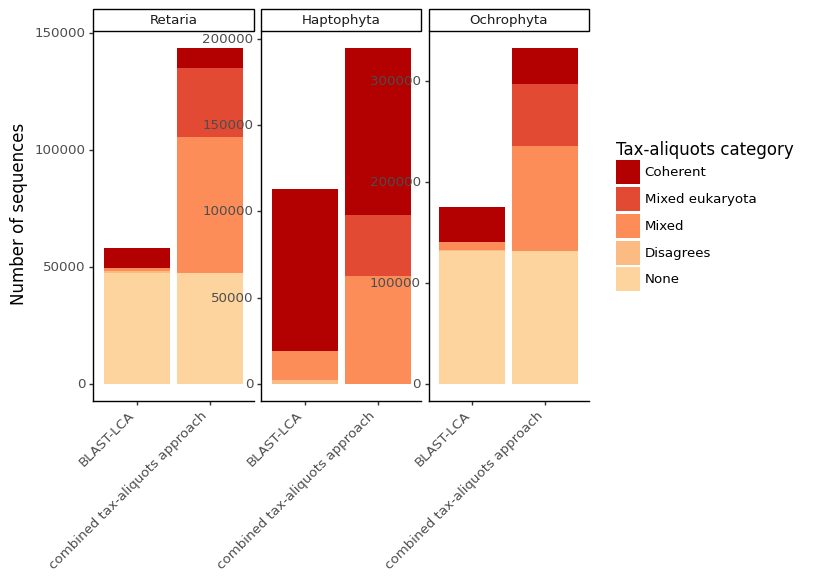

<ggplot: (2933013370667)>

In [13]:
retaria_group=retaria_subframe.groupby(["AnnotationType"]).transcript_name.sum().reset_index()
retaria_group["Phylum"]="Retaria"
diatom_group=diatom_subframe.groupby(["AnnotationType"]).transcript_name.sum().reset_index()
diatom_group["Phylum"]="Ochrophyta"
haptophyte_group=haptophyta_subframe.groupby(["AnnotationType"]).transcript_name.sum().reset_index()
haptophyte_group["Phylum"]="Haptophyta"
concat_frame=pd.concat([retaria_group,diatom_group,haptophyte_group])
concat_frame["AnnotationTypeCat"] = pd.Categorical(concat_frame["AnnotationType"],
                                                categories=["BLAST LCA","BLAST LCA, tax-aliquots coherent",
                                                            "BLAST LCA, tax-aliquots mixed",
                                                            "BLAST LCA, tax-aliquots disagrees",
                                                            "tax-aliquots",
                                                            "tax-aliquots coherent,BLAST LCA disagrees",
                                                            "tax-aliquots eukaryote",
                                                            "tax-aliquots coherent"],ordered=True)

concat_frame["Has BLAST-LCA"] = ["Yes" if "BLAST LCA" in curr else "No" for curr in\
                                concat_frame["AnnotationType"]]
concat_frame["Tax-aliquots"] = ["None" if "tax-aliquots" not in curr else \
                               "Mixed eukaryota" if ("eukaryote" in curr) else \
                               "Mixed" if ("tax-aliquots mixed" in curr)|(curr=="tax-aliquots") else \
                               "Coherent" if ("tax-aliquots coherent" in curr) else \
                                "Disagrees" if ("disagrees" in curr)&("BLAST LCA," in curr) else curr for curr in \
                                concat_frame["AnnotationType"]]
concat_frame["Tax-aliquots cat"]=pd.Categorical(concat_frame["Tax-aliquots"],
                                           categories=["Coherent",
                                                       "Mixed eukaryota",
                                                       "Mixed",
                                                       "Disagrees",
                                                       "None"])

concat_frame["Assessment category"] = [["BLAST-LCA"] if \
                                      ("BLAST LCA" in annotorigin)&\
                                      (("disagrees" in annotorigin)) else\
                                      ["BLAST-LCA","combined tax-aliquots approach"] if \
                                       ("BLAST LCA" in annotorigin) else \
                                      ["combined tax-aliquots approach"] for annotorigin \
                                      in concat_frame["AnnotationType"]]

for_plot = concat_frame.explode("Assessment category")

for_plot["type_cat"]=pd.Categorical(for_plot["Phylum"],
                                           categories=["Retaria","Haptophyta",
                                                       "Ochrophyta"])

diatom_plot_2 = (plotnine.ggplot(for_plot) + plotnine.geom_bar(plotnine.aes(x="Assessment category",
                                                                          y="transcript_name",
                                                             fill="Tax-aliquots cat"),stat="identity") + \
    plotnine.xlab("") + \
    plotnine.ylab("Number of sequences") +\
    plotnine.scale_fill_manual(values=["#b30000","#e34a33","#fc8d59",
                                       "#fdbb84","#fdd49e"],
                               name="Tax-aliquots category")+\
    plotnine.theme_classic(base_size=12) +
    plotnine.theme(axis_text_x=plotnine.element_text(rotation=45, hjust=1)) + 
    plotnine.facet_wrap("type_cat",scales="free_y"))
diatom_plot_2.save("retaria_tax_aliquots.pdf")
diatom_plot_2

In [24]:
for_plot.to_csv("bats-tax-aliquots.csv")

/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.


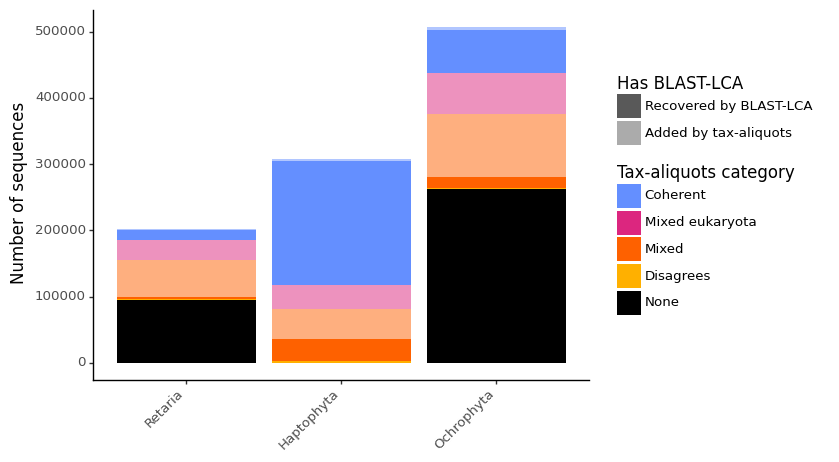

<ggplot: (2933016245833)>

In [22]:
(plotnine.ggplot(for_plot) + plotnine.geom_bar(plotnine.aes(x="type_cat",
                                                                          y="transcript_name",
                                                             fill="Tax-aliquots cat",
                                                            alpha="Has BLAST-LCA"),stat="identity") + \
    plotnine.xlab("") + \
    plotnine.scale_alpha_manual(values=[0.5,1],
                                breaks=["Yes","No"],
                                labels=["Recovered by BLAST-LCA",
                                        "Added by tax-aliquots"],
                                name="")+\
    plotnine.ylab("Number of sequences") +\
    plotnine.scale_fill_manual(values=["#648FFF","#DC267F",
                                       "#FE6100","#FFB000","black"],
                               name="Tax-aliquots category")+\
    plotnine.theme_classic(base_size=12) +
    plotnine.theme(axis_text_x=plotnine.element_text(rotation=45, hjust=1)))

In [26]:
for_plot.groupby(["type_cat","Tax-aliquots","Has BLAST-LCA"]).transcript_name.sum().reset_index()

,type_cat,Tax-aliquots,Has BLAST-LCA,transcript_name
0,Retaria,Coherent,No,1526
1,Retaria,Coherent,Yes,15427
2,Retaria,Disagrees,No,0
3,Retaria,Disagrees,Yes,781
4,Retaria,Mixed,No,56565
5,Retaria,Mixed,Yes,3190
6,Retaria,Mixed eukaryota,No,29658
7,Retaria,Mixed eukaryota,Yes,0
8,Retaria,None,No,0
9,Retaria,None,Yes,94780


In [28]:
len(for_plot.groupby(["type_cat","Tax-aliquots","Has BLAST-LCA"]).transcript_name.sum().reset_index().index)

30

In [27]:
len(for_plot.index)

31